In [1]:
# purpose of notebook: read in surface air temperature from CESM-LE simulations, plot the change in temp with 4xCO2
# and show at what point the different becomes significant 

# By: Ty Janoski
# Updated: 05.17.21

In [2]:
# Import libraries and make svg images the default for inline plots

%matplotlib inline
%config InlineBackend.figure_format = "pdf"
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

In [3]:
# create function for taking spatial averages, while weighting for latitude
def spatial_mean(ds_in, lat_bound_s = -91, lat_bound_n = 91):
    """
    Use xarray/numpy to calculate spatial average while weighting for latitude.
    
    Keyword arguments:
    ds_in -- Dataset or DataArray to take the average of
    lat_bound_s -- float, Southern boundary of area to average
    lat_bound_n -- float, Northern boundary of area to average
    """
    zonal = ds_in.mean(dim='lon').sel(lat=slice(lat_bound_s,lat_bound_n))
    weights = np.cos(np.deg2rad(zonal.lat)) / np.sum(np.cos(np.deg2rad(zonal.lat)))
    return((zonal * weights).sum(dim='lat'))

In [4]:
# create function for reading in cesm-LE output
# note: each ensemble member starts on january of a different year
# please keep this in mind when combining datasets
def read_in(exp,mon,ens,var):
    """
    Use xarray to read in a netCDF file.

    Keyword arguments:
    exp -- CO2 scenario
    mon -- starting month in which CO2 is altered
    ens -- ensemble number
    var -- model output variable
    """
    filein = '/dx05/janoski/d10/Arctic_Research/cesm-LE/output/b40.1850.cam5-lens.'+exp+'.'+str(
        f"{mon:02d}")+'.'+str(f"{ens:02d}")+'.h1_'+var+'.nc'
    return(xr.open_dataset(filein,chunks=None))

In [5]:
# read in each ensemble member, both control and 4xCO2
# Take the difference of each pair

diff_jan = []
# diff_jul = []
for e in range(1,101,1):
#for e in [x for x in range(1,41,1) if x != 3]:
#     print(e)
    # there are currently 20 ensemble members
    ctrl = read_in('ctrl',1,e,'TREFHT').TREFHT
    exp = read_in('4xCO2',1,e,'TREFHT').TREFHT
    
    
    # take diff
    diff = exp - ctrl
    
    # the timestamps on all the output is different because of the variable start years used in generating the ensemble members
    # we are going to override the existing time coordinate
    diff['time'] = np.arange(0,730,1)
    
    # add difference to list
    diff_jan.append(diff)
    
    # we will do the same process for july
    # there are currently 20 ensemble members
#     ctrl = read_in('ctrl',7,e,'TREFHT').TREFHT
#     exp = read_in('4xCO2',7,e,'TREFHT').TREFHT
    
    
#     # take diff
#     diff = exp - ctrl
    
#     # the timestamps on all the output is different because of the variable start years used in generating the ensemble members
#     # we are going to override the existing time coordinate
#     diff['time'] = np.arange(0,730,1)
    
#     # add difference to list
#     diff_jul.append(diff)
    
# convert list to xarray dataset
diff_jan = xr.concat(diff_jan,dim='ensemble')
# diff_jul = xr.concat(diff_jul,dim='ensemble')

In [6]:
# calculate mean and spread for both global and Arctic using spatial mean function
# see spatial mean function above for further details

glb_mean_jan = spatial_mean(diff_jan).mean(dim='ensemble')
glb_std_jan = spatial_mean(diff_jan).std(dim='ensemble')
arc_mean_jan = spatial_mean(diff_jan,lat_bound_s=70).mean(dim='ensemble')
arc_std_jan = spatial_mean(diff_jan,lat_bound_s=70).std(dim='ensemble')

# glb_mean_jul = spatial_mean(diff_jul).mean(dim='ensemble')
# glb_std_jul = spatial_mean(diff_jul).std(dim='ensemble')
# arc_mean_jul = spatial_mean(diff_jul,lat_bound_s=70).mean(dim='ensemble')
# arc_std_jul = spatial_mean(diff_jul,lat_bound_s=70).std(dim='ensemble')

In [7]:
# let's also see when the difference between arctic and global average temperature is significantly
# different from 0
arc_minus_glb_jan = spatial_mean(diff_jan,lat_bound_s=70,lat_bound_n=91) - spatial_mean(diff_jan)
# arc_minus_glb_jul = spatial_mean(diff_jul,lat_bound_s=70,lat_bound_n=91) - spatial_mean(diff_jul)

tvals_jan = arc_minus_glb_jan.mean(dim='ensemble') / (arc_minus_glb_jan.std(dim='ensemble') / np.sqrt(len(arc_minus_glb_jan.ensemble)))
# tvals_jul = arc_minus_glb_jul.mean(dim='ensemble') / (arc_minus_glb_jul.std(dim='ensemble') / np.sqrt(len(arc_minus_glb_jul.ensemble)))

In [8]:
t,p = stats.ttest_ind(spatial_mean(diff_jan,lat_bound_s=60),spatial_mean(diff_jan),equal_var=False)

In [11]:
# create figure object
fig, ax = plt.subplots()

xs = np.arange(1,731,1)

first_days = np.array([1,91,182,274])

x_vals = np.concatenate((first_days,first_days+365))
x_labs = np.tile(['Jan 1','Apr 1','Jul 1','Oct 1'],
                 (2))

# plot 4xCO2 starting in Jan
ax.plot(xs, glb_mean_jan, color='blue',label='global')
ax.fill_between(xs, glb_mean_jan-glb_std_jan, glb_mean_jan+glb_std_jan,color='blue',alpha=0.4)
ax.plot(xs, arc_mean_jan, color='red',label='Arctic')
ax.fill_between(xs, arc_mean_jan-arc_std_jan, arc_mean_jan+arc_std_jan,color='red',alpha=0.4)
# ax[2,0].set_ylim([-3,14])
ax.set_xlim([1,731])

ax.tick_params(axis='x', rotation=45,labelsize=8)
ax.tick_params(axis='y',labelsize=8)
ax.set_ylabel(r'$\Delta$SAT',fontsize=10)
# ax[2,0].set_title(r'Change in SAT, 4xCO$_2$ in Jan, 30 ens. members',fontsize=10)
ax.legend(loc='upper left')
ax.grid()

# plot the difference in SAT starting in Jan
# dotted = t <= 2.262
# ax[1].plot(xs, arc_minus_glb_jan.mean(dim='ensemble').where(abs(tvals_jan) > 2.0), color='black')
ax.set_xticks(x_vals)
ax.set_xticklabels(x_labs)
ax.tick_params(axis='x', rotation=45,labelsize=8)
ax.tick_params(axis='y',labelsize=8)
# ax[2,1].set_title(r'Change in SAT, Arctic-Global',fontsize=10)

plt.tight_layout()
plt.show()

<Figure size 432x288 with 1 Axes>

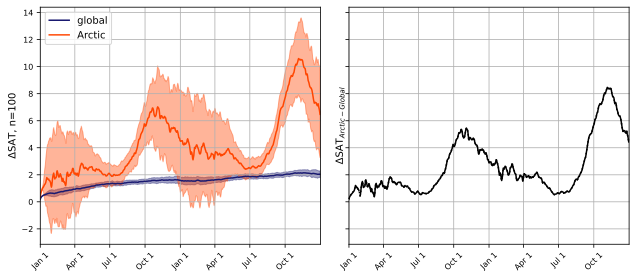

In [9]:
# create figure object
fig, ax = plt.subplots(ncols=2,figsize=(9,4),sharey=True,sharex=True)

xs = np.arange(1,731,1)

first_days = np.array([1,91,182,274])

x_vals = np.concatenate((first_days,first_days+365))
x_labs = np.tile(['Jan 1','Apr 1','Jul 1','Oct 1'],
                 (2))

# plot 4xCO2 starting in Jan
ax[0].plot(xs, glb_mean_jan, color='midnightblue',label='global')
ax[0].fill_between(xs, glb_mean_jan-glb_std_jan, glb_mean_jan+glb_std_jan,color='midnightblue',alpha=0.4)
ax[0].plot(xs, arc_mean_jan, color='orangered',label='Arctic')
ax[0].fill_between(xs, arc_mean_jan-arc_std_jan, arc_mean_jan+arc_std_jan,color='orangered',alpha=0.4)
# ax[2,0].set_ylim([-3,14])
ax[0].set_xlim([1,731])

ax[0].tick_params(axis='x', rotation=45,labelsize=8)
ax[0].tick_params(axis='y',labelsize=8)
ax[0].set_ylabel(r'$\Delta$SAT, n=100',fontsize=10)
# ax[2,0].set_title(r'Change in SAT, 4xCO$_2$ in Jan, 30 ens. members',fontsize=10)
ax[0].legend(loc='upper left')
ax[0].grid()

# plot the difference in SAT starting in Jan
# dotted = t <= 2.262
# ax[1].plot(xs, arc_minus_glb_jan.mean(dim='ensemble').where(abs(tvals_jan) > 2.0), color='black')
ax[1].plot(xs, arc_minus_glb_jan.mean(dim='ensemble').where(p<0.05), color='black')
ax[1].plot(xs, arc_minus_glb_jan.mean(dim='ensemble'), color='black',linestyle=':')
ax[1].set_xlim([1,731])
ax[1].set_xticks(x_vals)
ax[1].set_xticklabels(x_labs)
ax[1].tick_params(axis='x', rotation=45,labelsize=8)
ax[1].tick_params(axis='y',labelsize=8)
ax[1].set_ylabel(r'$\Delta$SAT$_{Arctic-Global}$',fontsize=10)
# ax[2,1].set_title(r'Change in SAT, Arctic-Global',fontsize=10)
ax[1].grid()

plt.tight_layout()
plt.show()

In [17]:
# create figure object
fig, ax = plt.subplots(ncols=2,nrows=4,figsize=(9,8),sharey=True,sharex=True)

xs = np.arange(1,731,1)

first_days = np.array([1,91,182,274])

x_vals = np.concatenate((first_days,first_days+365))
x_labs = np.tile(['Jan 1','Apr 1','Jul 1','Oct 1'],
                 (2))

glb = spatial_mean(diff_jan.isel(ensemble=slice(0,10)))
arc = spatial_mean(diff_jan.isel(ensemble=slice(0,10)),lat_bound_s=70)
diff = arc - glb
tvals = diff.mean(dim='ensemble') / (diff.std(dim='ensemble') / np.sqrt(len(diff.ensemble)))

ax[0,0].plot(xs, glb.mean(dim='ensemble'), color='blue',label='global')
ax[0,0].fill_between(xs, glb.mean(dim='ensemble')-glb.std(dim='ensemble'), glb.mean(dim='ensemble')+glb.std(dim='ensemble'),
                     color='blue',alpha=0.4)
ax[0,0].plot(xs, arc.mean(dim='ensemble'), color='red',label='Arctic')
ax[0,0].fill_between(xs, arc.mean(dim='ensemble')-arc.std(dim='ensemble'), arc.mean(dim='ensemble')+arc.std(dim='ensemble'),color='red',alpha=0.4)
ax[0,0].set_xlim([1,731])
ax[0,0].set_yticks(np.arange(-3,16,3))

ax[0,0].tick_params(axis='x', rotation=45,labelsize=8)
ax[0,0].tick_params(axis='y',labelsize=8)
ax[0,0].set_ylabel(r'$\Delta$SAT, n=10',fontsize=10)
ax[0,0].legend(loc='upper left')
ax[0,0].grid()

ax[0,1].plot(xs, diff.mean(dim='ensemble').where(abs(tvals) > 2.262), color='black')
ax[0,1].plot(xs, diff.mean(dim='ensemble'), color='black',linestyle=':')
ax[0,1].set_xlim([1,731])
ax[0,1].set_xticks(x_vals)
ax[0,1].set_xticklabels(x_labs)
ax[0,1].tick_params(axis='x', rotation=45,labelsize=8)
ax[0,1].tick_params(axis='y',labelsize=8)
ax[0,1].set_ylabel(r'$\Delta$SAT$_{Arctic-Global}$',fontsize=10)
ax[0,1].grid()

glb = spatial_mean(diff_jan.isel(ensemble=slice(0,25)))
arc = spatial_mean(diff_jan.isel(ensemble=slice(0,25)),lat_bound_s=70)
diff = arc - glb
tvals = diff.mean(dim='ensemble') / (diff.std(dim='ensemble') / np.sqrt(len(diff.ensemble)))

ax[1,0].plot(xs, glb.mean(dim='ensemble'), color='blue',label='global')
ax[1,0].fill_between(xs, glb.mean(dim='ensemble')-glb.std(dim='ensemble'), glb.mean(dim='ensemble')+glb.std(dim='ensemble'),
                     color='blue',alpha=0.4)
ax[1,0].plot(xs, arc.mean(dim='ensemble'), color='red',label='Arctic')
ax[1,0].fill_between(xs, arc.mean(dim='ensemble')-arc.std(dim='ensemble'), arc.mean(dim='ensemble')+arc.std(dim='ensemble'),color='red',alpha=0.4)

ax[1,0].tick_params(axis='x', rotation=45,labelsize=8)
ax[1,0].tick_params(axis='y',labelsize=8)
ax[1,0].set_ylabel(r'$\Delta$SAT, n=25',fontsize=10)
ax[1,0].grid()

ax[1,1].plot(xs, diff.mean(dim='ensemble').where(abs(tvals) > 2.064), color='black')
ax[1,1].plot(xs, diff.mean(dim='ensemble'), color='black',linestyle=':')
ax[1,1].tick_params(axis='x', rotation=45,labelsize=8)
ax[1,1].tick_params(axis='y',labelsize=8)
ax[1,1].set_ylabel(r'$\Delta$SAT$_{Arctic-Global}$',fontsize=10)
ax[1,1].grid()

glb = spatial_mean(diff_jan.isel(ensemble=slice(0,50)))
arc = spatial_mean(diff_jan.isel(ensemble=slice(0,50)),lat_bound_s=70)
diff = arc - glb
tvals = diff.mean(dim='ensemble') / (diff.std(dim='ensemble') / np.sqrt(len(diff.ensemble)))

ax[2,0].plot(xs, glb.mean(dim='ensemble'), color='blue',label='global')
ax[2,0].fill_between(xs, glb.mean(dim='ensemble')-glb.std(dim='ensemble'), glb.mean(dim='ensemble')+glb.std(dim='ensemble'),
                     color='blue',alpha=0.4)
ax[2,0].plot(xs, arc.mean(dim='ensemble'), color='red',label='Arctic')
ax[2,0].fill_between(xs, arc.mean(dim='ensemble')-arc.std(dim='ensemble'), arc.mean(dim='ensemble')+arc.std(dim='ensemble'),color='red',alpha=0.4)

ax[2,0].tick_params(axis='x', rotation=45,labelsize=8)
ax[2,0].tick_params(axis='y',labelsize=8)
ax[2,0].set_ylabel(r'$\Delta$SAT, n=50',fontsize=10)
ax[2,0].grid()

ax[2,1].plot(xs, diff.mean(dim='ensemble').where(abs(tvals) > 2.0105), color='black')
ax[2,1].plot(xs, diff.mean(dim='ensemble'), color='black',linestyle=':')
ax[2,1].tick_params(axis='x', rotation=45,labelsize=8)
ax[2,1].tick_params(axis='y',labelsize=8)
ax[2,1].set_ylabel(r'$\Delta$SAT$_{Arctic-Global}$',fontsize=10)
ax[2,1].grid()

glb = spatial_mean(diff_jan.isel(ensemble=slice(0,100)))
arc = spatial_mean(diff_jan.isel(ensemble=slice(0,100)),lat_bound_s=70)
diff = arc - glb
tvals = diff.mean(dim='ensemble') / (diff.std(dim='ensemble') / np.sqrt(len(diff.ensemble)))

ax[3,0].plot(xs, glb.mean(dim='ensemble'), color='blue',label='global')
ax[3,0].fill_between(xs, glb.mean(dim='ensemble')-glb.std(dim='ensemble'), glb.mean(dim='ensemble')+glb.std(dim='ensemble'),
                     color='blue',alpha=0.4)
ax[3,0].plot(xs, arc.mean(dim='ensemble'), color='red',label='Arctic')
ax[3,0].fill_between(xs, arc.mean(dim='ensemble')-arc.std(dim='ensemble'), arc.mean(dim='ensemble')+arc.std(dim='ensemble'),color='red',alpha=0.4)

ax[3,0].tick_params(axis='x', rotation=45,labelsize=8)
ax[3,0].tick_params(axis='y',labelsize=8)
ax[3,0].set_ylabel(r'$\Delta$SAT, n=100',fontsize=10)
ax[3,0].grid()

ax[3,1].plot(xs, diff.mean(dim='ensemble').where(abs(tvals) > 1.984), color='black')
ax[3,1].plot(xs, diff.mean(dim='ensemble'), color='black',linestyle=':')
ax[3,1].tick_params(axis='x', rotation=45,labelsize=8)
ax[3,1].tick_params(axis='y',labelsize=8)
ax[3,1].set_ylabel(r'$\Delta$SAT$_{Arctic-Global}$',fontsize=10)
ax[3,1].grid()

# Mike has requested text labels!
ax[0,0].text(650,-2,'(a)')
ax[1,0].text(650,-2,'(b)')
ax[2,0].text(650,-2,'(c)')
ax[3,0].text(650,-2,'(d)')
ax[0,1].text(650,-2,'(e)')
ax[1,1].text(650,-2,'(f)')
ax[2,1].text(650,-2,'(g)')
ax[3,1].text(650,-2,'(h)')



plt.tight_layout()
plt.savefig('dSAT_n_diff_incl.svg')

<Figure size 648x576 with 8 Axes>

In [18]:
# create figure object
fig, ax = plt.subplots(ncols=1,nrows=4,figsize=(7,7),sharey=True,sharex=True)

xs = np.arange(1,731,1)

first_days = np.array([1,91,182,274])

x_vals = np.concatenate((first_days,first_days+365))
x_labs = np.tile(['Jan 1','Apr 1','Jul 1','Oct 1'],
                 (2))

glb = spatial_mean(diff_jan.isel(ensemble=slice(0,10)))
arc = spatial_mean(diff_jan.isel(ensemble=slice(0,10)),lat_bound_s=70)
diff = arc - glb
tvals = diff.mean(dim='ensemble') / (diff.std(dim='ensemble') / np.sqrt(len(diff.ensemble)))

ax[0].plot(xs, arc.mean(dim='ensemble'), color='red',label='Arctic')
ax[0].fill_between(xs, arc.mean(dim='ensemble')-arc.std(dim='ensemble'), arc.mean(dim='ensemble')+arc.std(dim='ensemble'),color='red',alpha=0.4)
ax[0].plot(xs, glb.mean(dim='ensemble'), color='blue',label='global')
ax[0].fill_between(xs, glb.mean(dim='ensemble')-glb.std(dim='ensemble'), glb.mean(dim='ensemble')+glb.std(dim='ensemble'),
                     color='blue',alpha=0.4)
ax[0].set_xlim([1,731])
ax[0].set_yticks(np.arange(-3,16,3))

ax[0].tick_params(axis='x', rotation=45,labelsize=8)
ax[0].tick_params(axis='y',labelsize=8)
ax[0].set_ylabel(r'$\Delta$SAT, n=10',fontsize=10)
ax[0].legend(loc='upper left')
ax[0].grid()


glb = spatial_mean(diff_jan.isel(ensemble=slice(0,25)))
arc = spatial_mean(diff_jan.isel(ensemble=slice(0,25)),lat_bound_s=70)
diff = arc - glb
tvals = diff.mean(dim='ensemble') / (diff.std(dim='ensemble') / np.sqrt(len(diff.ensemble)))

ax[1].plot(xs, glb.mean(dim='ensemble'), color='blue',label='global')
ax[1].fill_between(xs, glb.mean(dim='ensemble')-glb.std(dim='ensemble'), glb.mean(dim='ensemble')+glb.std(dim='ensemble'),
                     color='blue',alpha=0.4)
ax[1].plot(xs, arc.mean(dim='ensemble'), color='red',label='Arctic')
ax[1].fill_between(xs, arc.mean(dim='ensemble')-arc.std(dim='ensemble'), arc.mean(dim='ensemble')+arc.std(dim='ensemble'),color='red',alpha=0.4)

ax[1].tick_params(axis='x', rotation=45,labelsize=8)
ax[1].tick_params(axis='y',labelsize=8)
ax[1].set_ylabel(r'$\Delta$SAT, n=25',fontsize=10)
ax[1].grid()


glb = spatial_mean(diff_jan.isel(ensemble=slice(0,50)))
arc = spatial_mean(diff_jan.isel(ensemble=slice(0,50)),lat_bound_s=70)
diff = arc - glb
tvals = diff.mean(dim='ensemble') / (diff.std(dim='ensemble') / np.sqrt(len(diff.ensemble)))

ax[2].plot(xs, glb.mean(dim='ensemble'), color='blue',label='global')
ax[2].fill_between(xs, glb.mean(dim='ensemble')-glb.std(dim='ensemble'), glb.mean(dim='ensemble')+glb.std(dim='ensemble'),
                     color='blue',alpha=0.4)
ax[2].plot(xs, arc.mean(dim='ensemble'), color='red',label='Arctic')
ax[2].fill_between(xs, arc.mean(dim='ensemble')-arc.std(dim='ensemble'), arc.mean(dim='ensemble')+arc.std(dim='ensemble'),color='red',alpha=0.4)

ax[2].tick_params(axis='x', rotation=45,labelsize=8)
ax[2].tick_params(axis='y',labelsize=8)
ax[2].set_ylabel(r'$\Delta$SAT, n=50',fontsize=10)
ax[2].grid()



glb = spatial_mean(diff_jan.isel(ensemble=slice(0,100)))
arc = spatial_mean(diff_jan.isel(ensemble=slice(0,100)),lat_bound_s=70)
diff = arc - glb
tvals = diff.mean(dim='ensemble') / (diff.std(dim='ensemble') / np.sqrt(len(diff.ensemble)))

ax[3].plot(xs, glb.mean(dim='ensemble'), color='blue',label='global')
ax[3].fill_between(xs, glb.mean(dim='ensemble')-glb.std(dim='ensemble'), glb.mean(dim='ensemble')+glb.std(dim='ensemble'),
                     color='blue',alpha=0.4)
ax[3].plot(xs, arc.mean(dim='ensemble'), color='red',label='Arctic')
ax[3].fill_between(xs, arc.mean(dim='ensemble')-arc.std(dim='ensemble'), arc.mean(dim='ensemble')+arc.std(dim='ensemble'),color='red',alpha=0.4)

ax[3].tick_params(axis='x', rotation=45,labelsize=8)
ax[3].tick_params(axis='y',labelsize=8)
ax[3].set_ylabel(r'$\Delta$SAT, n=100',fontsize=10)
ax[3].grid()

ax[3].set_xticks(x_vals)
ax[3].set_xticklabels(x_labs)



# Mike has requested text labels!
ax[0].text(650,-2,'(a)')
ax[1].text(650,-2,'(b)')
ax[2].text(650,-2,'(c)')
ax[3].text(650,-2,'(d)')




plt.tight_layout()
plt.savefig('dSAT_n_diff_exclud.svg')

<Figure size 504x504 with 4 Axes>

In [ ]:
glb_mean_jan = spatial_mean(diff_jan).mean(dim='ensemble')
glb_std_jan = spatial_mean(diff_jan).std(dim='ensemble')
arc_mean_jan = spatial_mean(diff_jan,lat_bound_s=70).mean(dim='ensemble')
arc_std_jan = spatial_mean(diff_jan,lat_bound_s=70).std(dim='ensemble')
arc_minus_glb_jan = spatial_mean(diff_jan,lat_bound_s=70,lat_bound_n=91) - spatial_mean(diff_jan)
tvals_jan = arc_minus_glb_jan.mean(dim='ensemble') / (arc_minus_glb_jan.std(dim='ensemble') / np.sqrt(len(arc_minus_glb_jan.ensemble)))

In [ ]:
arc_minus_glb_jan.mean(dim='ensemble').argmin(dim='time')

In [ ]:
ys = np.array(spatial_mean(diff_jan,lat_bound_s=70).sel(time=66))
xs = np.zeros(ys.shape)

plt.scatter(xs,ys,alpha=0.6)
plt.tight_layout()
plt.grid()
plt.show()

In [ ]:
diff_jan['week'] = (diff_jan.time//7)+1
weekly_jan = diff_jan.groupby('week').mean(dim='time')

In [ ]:
glb_mean_jan = spatial_mean(weekly_jan).mean(dim='ensemble')
glb_std_jan = spatial_mean(weekly_jan).std(dim='ensemble')
arc_mean_jan = spatial_mean(weekly_jan,lat_bound_s=70).mean(dim='ensemble')
arc_std_jan = spatial_mean(weekly_jan,lat_bound_s=70).std(dim='ensemble')

In [ ]:
t,p = stats.ttest_ind(spatial_mean(weekly_jan,lat_bound_s=70),spatial_mean(weekly_jan),equal_var=False)

In [ ]:
# let's also see when the difference between arctic and global average temperature is significantly
# different from 0
arc_minus_glb_jan = spatial_mean(weekly_jan,lat_bound_s=70,lat_bound_n=91) - spatial_mean(weekly_jan)
# arc_minus_glb_jul = spatial_mean(diff_jul,lat_bound_s=70,lat_bound_n=91) - spatial_mean(diff_jul)

tvals_jan = arc_minus_glb_jan.mean(dim='ensemble') / (arc_minus_glb_jan.std(dim='ensemble') / np.sqrt(len(arc_minus_glb_jan.ensemble)))
# tvals_jul = arc_minus_glb_jul.mean(dim='ensemble') / (arc_minus_glb_jul.std(dim='ensemble') / np.sqrt(len(arc_minus_glb_jul.ensemble)))

In [ ]:
# create figure object
fig, ax = plt.subplots(ncols=2,figsize=(9,4),sharey=True)

xs = np.arange(1,106,1)

# plot 4xCO2 starting in Jan
ax[0].plot(xs, glb_mean_jan, color='midnightblue',label='global')
ax[0].fill_between(xs, glb_mean_jan-glb_std_jan, glb_mean_jan+glb_std_jan,color='midnightblue',alpha=0.4)
ax[0].plot(xs, arc_mean_jan, color='orangered',label='Arctic')
ax[0].fill_between(xs, arc_mean_jan-arc_std_jan, arc_mean_jan+arc_std_jan,color='orangered',alpha=0.4)
ax[0].set_ylim([-3,14])
ax[0].set_xlim([1,104])
ax[0].tick_params(axis='x', rotation=45,labelsize=8)
ax[0].tick_params(axis='y',labelsize=8)
ax[0].set_ylabel(r'$\Delta$SAT',fontsize=10)
ax[0].set_title(r'Change in SAT, 4xCO$_2$ in Jan, 20 ens. members',fontsize=10)
ax[0].legend(loc='upper left')

# plot the difference in SAT starting in Jan
# dotted = t <= 2.262
ax[1].plot(xs, arc_minus_glb_jan.mean(dim='ensemble').where(abs(tvals_jan) > 2.091), color='black')
ax[1].plot(xs, arc_minus_glb_jan.mean(dim='ensemble'), color='black',linestyle=':')
ax[1].set_xlim([1,104])
ax[1].tick_params(axis='x', rotation=45,labelsize=8)
ax[1].tick_params(axis='y',labelsize=8)
ax[1].set_ylabel(r'$\Delta$SAT$_{Arctic-Global}$',fontsize=10)
ax[1].set_title(r'Change in SAT, Arctic-Global',fontsize=10)
ax[1].grid()


plt.tight_layout()
plt.show()
# plt.savefig('temp_vs_time_jan_042020.pdf')

In [ ]:
# create figure object
fig, ax = plt.subplots(ncols=2,figsize=(9,4),sharey=True)

xs = np.arange(1,731,1)

# Do some manipulation to be able to plot the time axis as the first of each month
first_days = np.array([1,92,184,274])
x_vals = np.concatenate((first_days,first_days+365))
x_labs = np.tile(['Jul 1','Oct 1','Jan 1','Apr 1'],
                 (2))

# plot 4xCO2 starting in jul
ax[0].plot(xs, glb_mean_jul, color='midnightblue',label='global')
ax[0].fill_between(xs, glb_mean_jul-glb_std_jul, glb_mean_jul+glb_std_jul,color='midnightblue',alpha=0.4)
ax[0].plot(xs, arc_mean_jul, color='orangered',label='Arctic')
ax[0].fill_between(xs, arc_mean_jul-arc_std_jul, arc_mean_jul+arc_std_jul,color='orangered',alpha=0.4)
ax[0].set_xlim([1,731])
ax[0].set_xticks(x_vals)
ax[0].set_xticklabels(x_labs)
ax[0].tick_params(axis='x', rotation=45,labelsize=8)
ax[0].tick_params(axis='y',labelsize=8)
ax[0].set_ylabel(r'$\Delta$SAT',fontsize=10)
ax[0].set_title(r'Change in SAT, 4xCO$_2$ in jul',fontsize=10)
ax[0].legend(loc='best')

# plot the difference in SAT starting in jul
# dotted = t <= 2.262
ax[1].plot(xs, arc_minus_glb_jul.mean(dim='ensemble').where(tvals_jul > 2.093), color='black')
ax[1].plot(xs, arc_minus_glb_jul.mean(dim='ensemble'), color='black',linestyle=':')
ax[1].set_xlim([1,731])
ax[1].set_xticks(x_vals)
ax[1].set_xticklabels(x_labs)
ax[1].tick_params(axis='x', rotation=45,labelsize=8)
ax[1].tick_params(axis='y',labelsize=8)
ax[1].set_ylabel(r'$\Delta$SAT$_{Arctic-Global}$',fontsize=10)
ax[1].set_title(r'Change in SAT, Arctic-Global',fontsize=10)


plt.tight_layout()
plt.show()
# plt.savefig('temp_vs_time_jul_042020.pdf')

In [ ]:
# create figure object
fig, ax = plt.subplots(ncols=2,figsize=(9,4),sharey=True)

xs = np.arange(0,730,1)

# Do some manipulation to be able to plot the time axis as the first of each month
x_vals = np.arange(0,32,5)
x_labs = ['Jul 1','Jul 6','Jul 11','Jul 16','Jul 21','Jul 26','Jul 31']

# plot 4xCO2 starting in Jul
ax[0].plot(xs, glb_mean_jul, color='midnightblue',label='global')
ax[0].fill_between(xs, glb_mean_jul-glb_std_jul, glb_mean_jul+glb_std_jul,color='midnightblue',alpha=0.4)
ax[0].plot(xs, arc_mean_jul, color='orangered',label='Arctic')
ax[0].fill_between(xs, arc_mean_jul-arc_std_jul, arc_mean_jul+arc_std_jul,color='orangered',alpha=0.4)
ax[0].set_xlim([0,30])
ax[0].set_xticks(x_vals)
ax[0].set_xticklabels(x_labs)
ax[0].tick_params(axis='x', rotation=45,labelsize=8)
ax[0].tick_params(axis='y',labelsize=8)
ax[0].set_ylabel(r'$\Delta$SAT',fontsize=10)
ax[0].set_title(r'Change in SAT, 4xCO$_2$ in jul',fontsize=10)
ax[0].legend(loc='best')

# plot the difference in SAT starting in Jul
# dotted = t <= 2.62
ax[1].plot(xs, aa_jul_em.where(t_vals_jul > 2.62), color='black')
ax[1].plot(xs, aa_jul_em, color='black',linestyle=':')
ax[1].set_xlim([0,30])
ax[1].set_xticks(x_vals)
ax[1].set_xticklabels(x_labs)
ax[1].tick_params(axis='x', rotation=45,labelsize=8)
ax[1].tick_params(axis='y',labelsize=8)
ax[1].set_ylabel(r'$\Delta$SAT$_{Arctic-Global}$',fontsize=10)
ax[1].set_title(r'Change in SAT, Arctic-Global',fontsize=10)


plt.tight_layout()
plt.show()
# plt.savefig('temp_vs_time_jul_one_month_042020.pdf')